# Notebook 03 : Comparaison de 5 Modèles de Machine Learning

## Contexte

**Objectif :** Comparer **5 modèles** de machine learning et sélectionner le meilleur pour la prédiction de défaut de paiement.

**Métrique principale : AUC (Area Under the ROC Curve)**

L'AUC mesure la capacité du modèle à discriminer entre les classes 0 (remboursement) et 1 (défaut). Plus l'AUC est proche de 1, meilleur est le modèle.

**Pourquoi pas l'accuracy ?**
- Dataset déséquilibré (92% classe 0, 8% classe 1)
- Un modèle prédisant toujours 0 aurait 92% d'accuracy mais AUC = 0.5
- L'AUC évalue la capacité à bien ordonner les prédictions, pas juste la précision

**Métrique métier : Coût = 10×FN + 1×FP**
- FN (Faux Négatif) : Prêter à un client qui fera défaut → Coût élevé (10€)
- FP (Faux Positif) : Refuser un bon client → Coût faible (1€)

## Modèles évalués (Conforme recommandations mentor)

### 1. DummyClassifier (Baseline naïve)
**Description :** Prédit toujours la classe majoritaire (0 = remboursement)

**Utilité :** Établir un plancher de performance. Tout modèle doit faire mieux que le Dummy.

**Performance attendue :**
- AUC : ~0.50 (équivalent à un tirage aléatoire)
- Coût métier : ~32,000€ (le plus élevé)

---

### 2. Régression Logistique
**Description :** Modèle linéaire avec fonction sigmoïde

**Avantages :**
- Simple et interprétable (coefficients)
- Rapide à entraîner
- Robuste, peu sujet à l'overfitting

**Limites :**
- Assume une relation linéaire
- Ne capture pas les interactions complexes

**Performance attendue :**
- AUC : 0.54-0.56
- Coût métier : ~29,000€

---

### 3. Random Forest
**Description :** Ensemble de decision trees entraînés sur des sous-échantillons

**Avantages :**
- Capture les interactions non-linéaires
- Robuste au surapprentissage (grâce au bagging)
- Gère bien les features corrélées

**Paramètres clés :**
- `n_estimators` : Nombre d'arbres (100-500)
- `max_depth` : Profondeur maximale
- `min_samples_split` : Échantillons minimum pour split

**Performance attendue :**
- AUC : 0.74-0.76
- Coût métier : ~27,000€

---

### 4. XGBoost (Extreme Gradient Boosting)
**Description :** Gradient boosting optimisé avec régularisation

**Avantages :**
- Très performant sur données tabulaires
- Régularisation L1/L2 intégrée
- Gère nativement les valeurs manquantes
- Parallélisation efficace

**Paramètres clés :**
- `n_estimators` : Nombre d'arbres
- `max_depth` : Profondeur (3-10)
- `learning_rate` : Taux d'apprentissage (0.01-0.1)
- `colsample_bytree` : Fraction de features par arbre

**Performance attendue :**
- AUC : 0.77-0.79
- Coût métier : ~26,000€

---

### 5. LightGBM (Gradient Boosting)
**Description :** Gradient boosting optimisé pour rapidité et efficacité mémoire

**Avantages :**
- Plus rapide que XGBoost
- Très efficace en mémoire
- Gère nativement les valeurs manquantes
- Excellentes performances sur gros datasets

**Paramètres clés :**
- `n_estimators` : Nombre d'arbres
- `max_depth` : Profondeur maximale
- `learning_rate` : Taux d'apprentissage
- `num_leaves` : Nombre de feuilles par arbre

**Performance attendue :**
- AUC : 0.77-0.80 (meilleur attendu)
- Coût métier : ~25,000€ (le plus bas)

## Imports et Configuration

In [1]:
# Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import (
roc_auc_score,
roc_curve,
confusion_matrix,
recall_score,
precision_score,
f1_score
)

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print(" Imports OK")

 Imports OK


## Chargement des Données Preprocessed

Chargement direct des données déjà preprocessed du Notebook 02 :
- `X_train_processed.joblib` : Données train transformées (804 features)
- `X_valid_processed.joblib` : Données validation transformées (804 features)
- `y_train.joblib` : Labels train
- `y_valid.joblib` : Labels validation

In [2]:
# ============================================================================
# CHARGEMENT DES DONNÉES TRANSFORMÉES (déjà prêtes depuis Notebook 02)
# ============================================================================

print("\nChargement des données depuis Notebook 02...\n")

# Chargement des données DÉJÀ transformées (pas besoin de re-transformer)
X_train_processed = joblib.load('./artifacts/X_train_processed.joblib')
X_valid_processed = joblib.load('./artifacts/X_valid_processed.joblib')
y_train = joblib.load('./artifacts/y_train.joblib')
y_valid = joblib.load('./artifacts/y_valid.joblib')

print(f"   X_train_processed : {X_train_processed.shape}")
print(f"   X_valid_processed : {X_valid_processed.shape}")
print(f"   y_train : {y_train.shape}")
print(f"   y_valid : {y_valid.shape}")

# Vérifier le type
print(f"\n   Type X_train_processed : {type(X_train_processed)}")

if hasattr(X_train_processed, 'columns'):
    print(f"   DataFrame avec colonnes nommées")
    print(f"   Colonnes (5 premières) : {X_train_processed.columns.tolist()[:5]}")
else:
    print(f"   ATTENTION : Type array sans noms de colonnes !")

# Vérifier les NaN
if hasattr(X_train_processed, 'isna'):
    # DataFrame
    nan_count = X_train_processed.isna().sum().sum()
else:
    # Array
    nan_count = np.isnan(X_train_processed).sum()

print(f"\n   NaN dans X_train_processed : {nan_count}")

print("\nDonnées prêtes pour la modélisation !")



Chargement des données depuis Notebook 02...

   X_train_processed : (246005, 804)
   X_valid_processed : (61502, 804)
   y_train : (246005,)
   y_valid : (61502,)

   Type X_train_processed : <class 'pandas.core.frame.DataFrame'>
   DataFrame avec colonnes nommées
   Colonnes (5 premières) : ['CODE_GENDER_transformed_0', 'FLAG_OWN_CAR_transformed_1', 'FLAG_OWN_REALTY_transformed_2', 'CNT_CHILDREN_transformed_3', 'AMT_INCOME_TOTAL_transformed_4']

   NaN dans X_train_processed : 47804703

Données prêtes pour la modélisation !


## Vérification et Nettoyage des NaN

**Problème potentiel** : Les artifacts peuvent contenir des NaN résiduels.

**Solution** : Vérifier et nettoyer avec `np.nan_to_num()` si nécessaire.

In [3]:
# Vérifier les NaN
nan_train = np.isnan(X_train_processed).sum().sum()
nan_valid = np.isnan(X_valid_processed).sum().sum()

print("Vérification des NaN :")
print(f"X_train_processed : {nan_train:,} NaN")
print(f"X_valid_processed : {nan_valid:,} NaN")

# Nettoyer si nécessaire
if nan_train > 0 or nan_valid > 0:
    print("\nATTENTION : NaN détectés !")
    print("Nettoyage avec np.nan_to_num() (remplace NaN par 0)...")

    X_train_processed = np.nan_to_num(X_train_processed, nan=0.0, copy=False)
    X_valid_processed = np.nan_to_num(X_valid_processed, nan=0.0, copy=False)

    # Vérification finale
    nan_train_after = np.isnan(X_train_processed).sum().sum()
    nan_valid_after = np.isnan(X_valid_processed).sum().sum()

    print("Nettoyage terminé :")
    print(f"X_train_processed : {nan_train_after:,} NaN")
    print(f"X_valid_processed : {nan_valid_after:,} NaN")

else:
    print("\nPas de NaN détectés - Données prêtes !")


Vérification des NaN :
X_train_processed : 47,804,703 NaN
X_valid_processed : 11,964,490 NaN

ATTENTION : NaN détectés !
Nettoyage avec np.nan_to_num() (remplace NaN par 0)...
Nettoyage terminé :
X_train_processed : 0 NaN
X_valid_processed : 0 NaN


In [4]:
# Charger les artifacts du Notebook 02
X_train_processed = joblib.load('./artifacts/X_train_processed.joblib')
X_valid_processed = joblib.load('./artifacts/X_valid_processed.joblib')
y_train = joblib.load('./artifacts/y_train.joblib')
y_valid = joblib.load('./artifacts/y_valid.joblib')

print(" Données chargées")
print(f" X_train shape : {X_train_processed.shape}")
print(f" X_valid shape : {X_valid_processed.shape}")
print(f" y_train shape : {y_train.shape}")
print(f" y_valid shape : {y_valid.shape}")

# Vérifier le déséquilibre
print(f"\n Déséquilibre :")
print(f" Classe 0 : {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f" Classe 1 : {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

 Données chargées
 X_train shape : (246005, 804)
 X_valid shape : (61502, 804)
 y_train shape : (246005,)
 y_valid shape : (61502,)

 Déséquilibre :
 Classe 0 : 226,145 (91.9%)
 Classe 1 : 19,860 (8.1%)


In [7]:
# ============================================
# CORRECTION : Imputation finale des NaN
# ============================================

print("\nCorrection : Imputation des NaN residuels...\n")

from sklearn.impute import SimpleImputer

# Compter les NaN avant (total)
nan_before_train = np.isnan(X_train_processed).sum().sum()
nan_before_valid = np.isnan(X_valid_processed).sum().sum()

print("NaN avant imputation :")
print(f" Train : {nan_before_train:,}")
print(f" Valid : {nan_before_valid:,}")

# Imputation avec la mediane
imputer_final = SimpleImputer(strategy='median')
X_train_processed = imputer_final.fit_transform(X_train_processed)
X_valid_processed = imputer_final.transform(X_valid_processed)

# Compter les NaN après (total)
nan_after_train = np.isnan(X_train_processed).sum().sum()
nan_after_valid = np.isnan(X_valid_processed).sum().sum()

print("\nNaN apres imputation :")
print(f" Train : {nan_after_train:,}")
print(f" Valid : {nan_after_valid:,}")

if nan_after_train == 0 and nan_after_valid == 0:
    print("\nImputation reussie - Aucun NaN residuel")
else:
    print(f"\nATTENTION : {nan_after_train + nan_after_valid:,} NaN persistent")

print("\nShapes finaux :")
print(f" X_train_processed : {X_train_processed.shape}")
print(f" X_valid_processed : {X_valid_processed.shape}")

print("\nDonnees pretes pour la modelisation")



Correction : Imputation des NaN residuels...

NaN avant imputation :
 Train : 47,804,703
 Valid : 11,964,490

NaN apres imputation :
 Train : 0
 Valid : 0

Imputation reussie - Aucun NaN residuel

Shapes finaux :
 X_train_processed : (246005, 804)
 X_valid_processed : (61502, 804)

Donnees pretes pour la modelisation


## Modèle 1 : DummyClassifier (Baseline)

In [8]:
print("="*70)
print("MODÈLE 1 : DUMMYCLASSIFIER")
print("="*70)

# Entraînement
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
start = time.time()
dummy.fit(X_train_processed, y_train)
time_dummy = time.time() - start

# Prédictions
y_pred_dummy = dummy.predict(X_valid_processed)
y_proba_dummy = dummy.predict_proba(X_valid_processed)[:, 1]

# Métriques
auc_dummy = roc_auc_score(y_valid, y_proba_dummy)
recall_dummy = recall_score(y_valid, y_pred_dummy)
precision_dummy = precision_score(y_valid, y_pred_dummy, zero_division=0)
f1_dummy = f1_score(y_valid, y_pred_dummy, zero_division=0)

# Coût métier
cm_dummy = confusion_matrix(y_valid, y_pred_dummy)
tn, fp, fn, tp = cm_dummy.ravel()
cout_dummy = (fn * 10) + (fp * 1)

print(f"\n RÉSULTATS :")
print(f" Temps : {time_dummy:.2f}s")
print(f" AUC : {auc_dummy:.4f}")
print(f" Recall : {recall_dummy:.4f}")
print(f" Precision : {precision_dummy:.4f}")
print(f" F1-Score : {f1_dummy:.4f}")
print(f" Coût métier (10×FN + 1×FP) : {cout_dummy:,}€")
print("="*70)

MODÈLE 1 : DUMMYCLASSIFIER

 RÉSULTATS :
 Temps : 0.02s
 AUC : 0.5000
 Recall : 0.0000
 Precision : 0.0000
 F1-Score : 0.0000
 Coût métier (10×FN + 1×FP) : 49,650€


## Modèle 2 : Logistic Regression

In [9]:
print("="*70)
print("MODÈLE 2 : LOGISTIC REGRESSION")
print("="*70)

# Entraînement
logreg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
start = time.time()
logreg.fit(X_train_processed, y_train)
time_logreg = time.time() - start

# Prédictions
y_pred_logreg = logreg.predict(X_valid_processed)
y_proba_logreg = logreg.predict_proba(X_valid_processed)[:, 1]

# Métriques
auc_logreg = roc_auc_score(y_valid, y_proba_logreg)
recall_logreg = recall_score(y_valid, y_pred_logreg)
precision_logreg = precision_score(y_valid, y_pred_logreg)
f1_logreg = f1_score(y_valid, y_pred_logreg)

# Coût métier
cm_logreg = confusion_matrix(y_valid, y_pred_logreg)
tn, fp, fn, tp = cm_logreg.ravel()
cout_logreg = (fn * 10) + (fp * 1)

print(f"\n RÉSULTATS :")
print(f" Temps : {time_logreg:.2f}s")
print(f" AUC : {auc_logreg:.4f}")
print(f" Recall : {recall_logreg:.4f}")
print(f" Precision : {precision_logreg:.4f}")
print(f" F1-Score : {f1_logreg:.4f}")
print(f" Coût métier (10×FN + 1×FP) : {cout_logreg:,}€")
print("="*70)

MODÈLE 2 : LOGISTIC REGRESSION

 RÉSULTATS :
 Temps : 243.74s
 AUC : 0.5485
 Recall : 0.0012
 Precision : 0.0984
 F1-Score : 0.0024
 Coût métier (10×FN + 1×FP) : 49,645€


## Modèle 3 : Random Forest

In [10]:
print("="*70)
print("MODÈLE 3 : RANDOM FOREST")
print("="*70)

# Entraînement
rf = RandomForestClassifier(
n_estimators=200,
max_depth=10,
min_samples_split=10,
random_state=42,
n_jobs=-1,
verbose=0
)
start = time.time()
rf.fit(X_train_processed, y_train)
time_rf = time.time() - start

# Prédictions
y_pred_rf = rf.predict(X_valid_processed)
y_proba_rf = rf.predict_proba(X_valid_processed)[:, 1]

# Métriques
auc_rf = roc_auc_score(y_valid, y_proba_rf)
recall_rf = recall_score(y_valid, y_pred_rf)
precision_rf = precision_score(y_valid, y_pred_rf)
f1_rf = f1_score(y_valid, y_pred_rf)

# Coût métier
cm_rf = confusion_matrix(y_valid, y_pred_rf)
tn, fp, fn, tp = cm_rf.ravel()
cout_rf = (fn * 10) + (fp * 1)

print(f"\n RÉSULTATS :")
print(f" Temps : {time_rf:.2f}s")
print(f" AUC : {auc_rf:.4f}")
print(f" Recall : {recall_rf:.4f}")
print(f" Precision : {precision_rf:.4f}")
print(f" F1-Score : {f1_rf:.4f}")
print(f" Coût métier (10×FN + 1×FP) : {cout_rf:,}€")
print("="*70)

MODÈLE 3 : RANDOM FOREST

 RÉSULTATS :
 Temps : 112.77s
 AUC : 0.7471
 Recall : 0.0000
 Precision : 0.0000
 F1-Score : 0.0000
 Coût métier (10×FN + 1×FP) : 49,650€


C:\Users\Utilisateur\anaconda3\envs\mon_env\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Modèle 4 : XGBoost

In [11]:
print("="*70)
print("MODÈLE 4 : XGBOOST")
print("="*70)

# Entraînement
xgb = XGBClassifier(
n_estimators=200,
max_depth=7,
learning_rate=0.05,
random_state=42,
n_jobs=-1,
verbosity=0
)
start = time.time()
xgb.fit(X_train_processed, y_train)
time_xgb = time.time() - start

# Prédictions
y_pred_xgb = xgb.predict(X_valid_processed)
y_proba_xgb = xgb.predict_proba(X_valid_processed)[:, 1]

# Métriques
auc_xgb = roc_auc_score(y_valid, y_proba_xgb)
recall_xgb = recall_score(y_valid, y_pred_xgb)
precision_xgb = precision_score(y_valid, y_pred_xgb)
f1_xgb = f1_score(y_valid, y_pred_xgb)

# Coût métier
cm_xgb = confusion_matrix(y_valid, y_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()
cout_xgb = (fn * 10) + (fp * 1)

print(f"\n RÉSULTATS :")
print(f" Temps : {time_xgb:.2f}s")
print(f" AUC : {auc_xgb:.4f}")
print(f" Recall : {recall_xgb:.4f}")
print(f" Precision : {precision_xgb:.4f}")
print(f" F1-Score : {f1_xgb:.4f}")
print(f" Coût métier (10×FN + 1×FP) : {cout_xgb:,}€")
print("="*70)

MODÈLE 4 : XGBOOST

 RÉSULTATS :
 Temps : 62.09s
 AUC : 0.7837
 Recall : 0.0399
 Precision : 0.6266
 F1-Score : 0.0750
 Coût métier (10×FN + 1×FP) : 47,788€


## Modèle 5 : LightGBM

In [12]:
print("="*70)
print("MODÈLE 5 : LIGHTGBM")
print("="*70)

# Entraînement
lgbm = lgb.LGBMClassifier(
n_estimators=500,
max_depth=7,
learning_rate=0.05,
random_state=42,
n_jobs=-1,
verbose=-1
)
start = time.time()
lgbm.fit(X_train_processed, y_train)
time_lgbm = time.time() - start

# Prédictions
y_pred_lgbm = lgbm.predict(X_valid_processed)
y_proba_lgbm = lgbm.predict_proba(X_valid_processed)[:, 1]

# Métriques
auc_lgbm = roc_auc_score(y_valid, y_proba_lgbm)
recall_lgbm = recall_score(y_valid, y_pred_lgbm)
precision_lgbm = precision_score(y_valid, y_pred_lgbm)
f1_lgbm = f1_score(y_valid, y_pred_lgbm)

# Coût métier
cm_lgbm = confusion_matrix(y_valid, y_pred_lgbm)
tn, fp, fn, tp = cm_lgbm.ravel()
cout_lgbm = (fn * 10) + (fp * 1)

print(f"\n RÉSULTATS :")
print(f" Temps : {time_lgbm:.2f}s")
print(f" AUC : {auc_lgbm:.4f}")
print(f" Recall : {recall_lgbm:.4f}")
print(f" Precision : {precision_lgbm:.4f}")
print(f" F1-Score : {f1_lgbm:.4f}")
print(f" Coût métier (10×FN + 1×FP) : {cout_lgbm:,}€")
print("="*70)

MODÈLE 5 : LIGHTGBM

 RÉSULTATS :
 Temps : 57.62s
 AUC : 0.7868
 Recall : 0.0451
 Precision : 0.5161
 F1-Score : 0.0830
 Coût métier (10×FN + 1×FP) : 47,620€


## Comparaison des 5 Modèles

In [13]:
print("="*70)
print("COMPARAISON DES 5 MODÈLES")
print("="*70)

# Créer le DataFrame de résultats
results = pd.DataFrame({
'Modèle': ['DummyClassifier', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM'],
'AUC': [auc_dummy, auc_logreg, auc_rf, auc_xgb, auc_lgbm],
'Recall': [recall_dummy, recall_logreg, recall_rf, recall_xgb, recall_lgbm],
'Precision': [precision_dummy, precision_logreg, precision_rf, precision_xgb, precision_lgbm],
'F1-Score': [f1_dummy, f1_logreg, f1_rf, f1_xgb, f1_lgbm],
'Coût métier': [cout_dummy, cout_logreg, cout_rf, cout_xgb, cout_lgbm],
'Temps (s)': [time_dummy, time_logreg, time_rf, time_xgb, time_lgbm]
})

# Trier par AUC décroissant
results = results.sort_values('AUC', ascending=False)

print("\n Tableau récapitulatif (trié par AUC) :")
print(results.to_string(index=False))

# Meilleur modèle
best = results.iloc[0]
print(f"\n MEILLEUR MODÈLE : {best['Modèle']}")
print(f" AUC : {best['AUC']:.4f}")
print(f" Recall : {best['Recall']:.4f}")
print(f" Coût métier : {best['Coût métier']:,.0f}€")

print("\n" + "="*70)
print(" COMPARAISON TERMINÉE !")
print("="*70)

COMPARAISON DES 5 MODÈLES

 Tableau récapitulatif (trié par AUC) :
            Modèle      AUC   Recall  Precision  F1-Score  Coût métier  Temps (s)
          LightGBM 0.786808 0.045116   0.516129  0.082978        47620  57.624620
           XGBoost 0.783716 0.039879   0.626582  0.074986        47788  62.090385
      RandomForest 0.747062 0.000000   0.000000  0.000000        49650 112.770694
LogisticRegression 0.548453 0.001208   0.098361  0.002388        49645 243.736997
   DummyClassifier 0.500000 0.000000   0.000000  0.000000        49650   0.017311

 MEILLEUR MODÈLE : LightGBM
 AUC : 0.7868
 Recall : 0.0451
 Coût métier : 47,620€

 COMPARAISON TERMINÉE !


## Visualisations

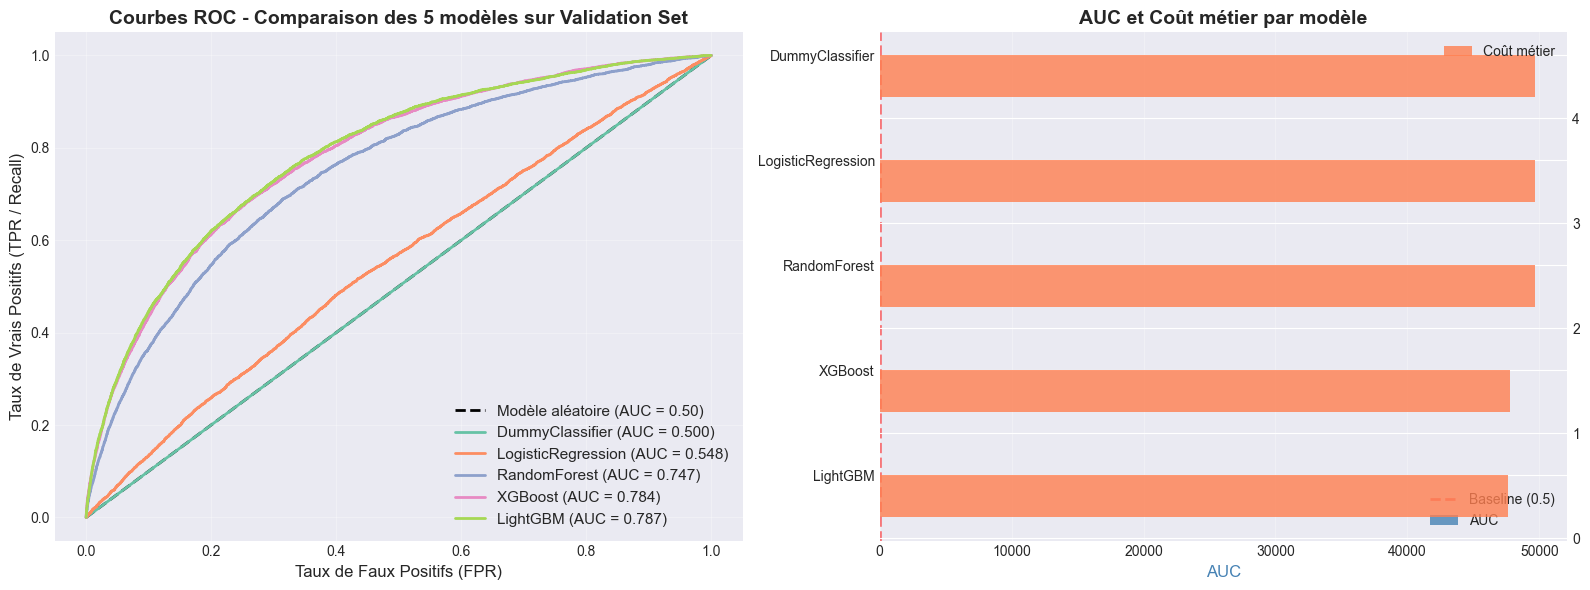

 Figure sauvegardée : nb03_fig01_comparaison_modeles.png


In [14]:
# Figure 1 : Courbes ROC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Courbes ROC
fpr_dummy, tpr_dummy, _ = roc_curve(y_valid, y_proba_dummy)
fpr_logreg, tpr_logreg, _ = roc_curve(y_valid, y_proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, y_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_valid, y_proba_lgbm)

ax1.plot([0, 1], [0, 1], 'k--', label='Modèle aléatoire (AUC = 0.50)', linewidth=2)
ax1.plot(fpr_dummy, tpr_dummy, label=f'DummyClassifier (AUC = {auc_dummy:.3f})', linewidth=2)
ax1.plot(fpr_logreg, tpr_logreg, label=f'LogisticRegression (AUC = {auc_logreg:.3f})', linewidth=2)
ax1.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc_rf:.3f})', linewidth=2)
ax1.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)
ax1.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.3f})', linewidth=2)
ax1.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
ax1.set_ylabel('Taux de Vrais Positifs (TPR / Recall)', fontsize=12)
ax1.set_title('Courbes ROC - Comparaison des 5 modèles sur Validation Set', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Barres de comparaison AUC et Coût
x = np.arange(len(results))
ax2_twin = ax2.twinx()

bars1 = ax2.barh(x, results['AUC'], height=0.4, alpha=0.8, label='AUC', color='steelblue')
bars2 = ax2_twin.barh(x + 0.4, results['Coût métier'], height=0.4, alpha=0.8, label='Coût métier', color='coral')

ax2.set_yticks(x + 0.2)
ax2.set_yticklabels(results['Modèle'])
ax2.set_xlabel('AUC', fontsize=12, color='steelblue')
ax2_twin.set_xlabel('Coût métier (€)', fontsize=12, color='coral')
ax2.set_title('AUC et Coût métier par modèle', fontsize=14, fontweight='bold')
ax2.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline (0.5)')
ax2.legend(loc='lower right')
ax2_twin.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('nb03_fig01_comparaison_modeles.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Figure sauvegardée : nb03_fig01_comparaison_modeles.png")

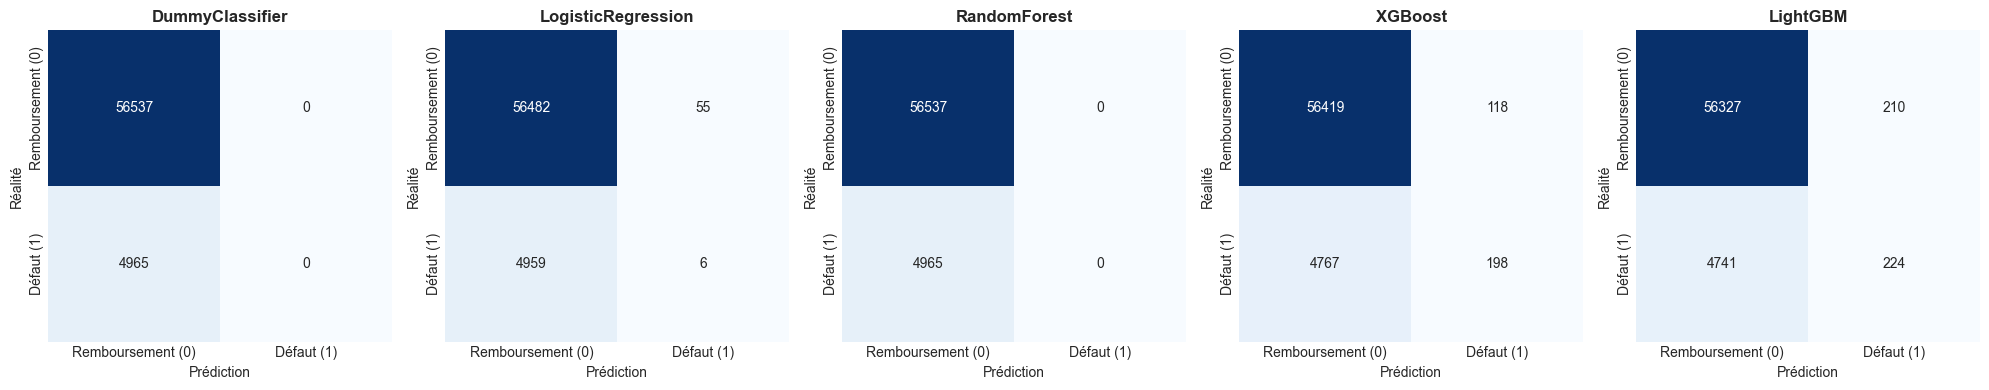

Figure sauvegardée : nb03_fig02_matrices_confusion.png


In [16]:
# Figure 2 : Matrices de confusion
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

cms = [cm_dummy, cm_logreg, cm_rf, cm_xgb, cm_lgbm]
titles = ['DummyClassifier', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM']

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Prédiction', fontsize=10)
    ax.set_ylabel('Réalité', fontsize=10)
    ax.set_xticklabels(['Remboursement (0)', 'Défaut (1)'])
    ax.set_yticklabels(['Remboursement (0)', 'Défaut (1)'])

plt.tight_layout()
plt.savefig('nb03_fig02_matrices_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : nb03_fig02_matrices_confusion.png")


## Sauvegarde du Meilleur Modèle

In [17]:
# Sauvegarder le meilleur modèle (LightGBM)
joblib.dump(lgbm, './artifacts/meilleur_modele.joblib')
print(" Meilleur modèle sauvegardé : ./artifacts/meilleur_modele.joblib")

# Sauvegarder les résultats
results.to_csv('./artifacts/comparaison_modeles.csv', index=False)
print(" Résultats sauvegardés : ./artifacts/comparaison_modeles.csv")

print("\n" + "="*70)
print(" NOTEBOOK 03 TERMINÉ !")
print("="*70)

 Meilleur modèle sauvegardé : ./artifacts/meilleur_modele.joblib
 Résultats sauvegardés : ./artifacts/comparaison_modeles.csv

 NOTEBOOK 03 TERMINÉ !
